In [1]:
Benchmark = False 
scalability_test  = True
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Set debug level to suppress warnings
import tensorflow as tf
import numpy as np
from utils.read_dataset_role import input_fn

# if Benchmark:
# 	from routenet_model import RouteNetModel
# else:
# 	from OldRouteRolxNet.routeNALU_GATDGCNResResDrop_CapacityNORM_dropmore import RouteNetModel

import configparser
# from utils.extra_eval import ExtraValidation
from utils.Transform import transformation, transformation_test #, transformation_pretrain
import matplotlib.pyplot as plt
import networkx as nx
import pygsp.graphs as g
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import seaborn as sns
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
from utils.datanetAPI import DatanetAPI

/tmp/ipykernel_5323/1592878212.py:22: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [22]:
# Read the config file
config = configparser.ConfigParser()
config._interpolation = configparser.ExtendedInterpolation()
config.read('config_res.ini')

['config_res.ini']

'/proj/raygnn/GNNetDataset/gnnet-ch21-dataset-train/'

In [5]:
ds_test_50 = input_fn(config['DIRECTORIES']['new_test'], shuffle=False,pre_processed=True, complete_info = True,filter_size = True, filter_operator = " == 50", debug = False)
ds_test_50 = ds_test_50.map(lambda x, y: transformation_test(x, y))
ds_test_50 = ds_test_50.prefetch(tf.data.experimental.AUTOTUNE)

ds_test_100 = input_fn(config['DIRECTORIES']['new_test'], shuffle=False,pre_processed=True, complete_info = True,filter_size = True, filter_operator = " == 100", debug = False)
ds_test_100 = ds_test_100.map(lambda x, y: transformation_test(x, y))
ds_test_100 = ds_test_100.prefetch(tf.data.experimental.AUTOTUNE)

ds_test_160 = input_fn(config['DIRECTORIES']['new_test'], shuffle=False,pre_processed=True, complete_info = True,filter_size = True, filter_operator = " == 160", debug = False)
ds_test_160 = ds_test_160.map(lambda x, y: transformation_test(x, y))
ds_test_160 = ds_test_160.prefetch(tf.data.experimental.AUTOTUNE)

ds_test_200 = input_fn(config['DIRECTORIES']['new_test'], shuffle=False,pre_processed=True, complete_info = True,filter_size = True, filter_operator = " == 200", debug = False)
ds_test_200 = ds_test_200.map(lambda x, y: transformation_test(x, y))
ds_test_200 = ds_test_200.prefetch(tf.data.experimental.AUTOTUNE)

ds_test_260 = input_fn(config['DIRECTORIES']['new_test'], shuffle=False,pre_processed=True, complete_info = True, filter_size = True, filter_operator = " == 260", debug = False)
ds_test_260 = ds_test_260.map(lambda x, y:transformation_test(x, y,  normalize_edge_weight_by_origin_capacity = False))
ds_test_260 = ds_test_260.prefetch(tf.data.experimental.AUTOTUNE)

ds_test_300 = input_fn(config['DIRECTORIES']['new_test'], shuffle=False,pre_processed=True, complete_info = True, filter_size = True, filter_operator = " == 300", debug = False)
ds_test_300 = ds_test_300.map(lambda x, y:transformation_test(x, y,  normalize_edge_weight_by_origin_capacity = False))
ds_test_300 = ds_test_300.prefetch(tf.data.experimental.AUTOTUNE)

2023-11-13 07:57:23.676486: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


/tmp/ipykernel_5323/3795383398.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  G = nx.from_numpy_matrix(nx.adjacency_matrix(next(iter(reader)).get_topology_object().copy().to_undirected()).todense())


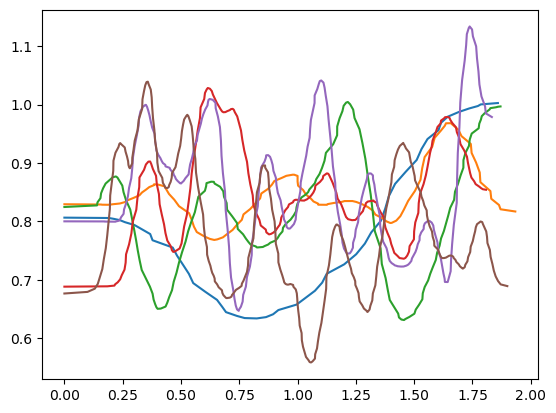

In [19]:
# Plot the un-process data
topology = [[50],[100],[160],[200],[260],[300]]
eigen_value = []
for top in topology:
    reader = DatanetAPI(config['DIRECTORIES']['train'],topology_sizes =top)
    G = nx.from_numpy_matrix(nx.adjacency_matrix(next(iter(reader)).get_topology_object().copy().to_undirected()).todense())
    G_pygsp = g.Graph.from_networkx(G)
    G_pygsp.compute_laplacian(lap_type='normalized')
    G_pygsp.compute_fourier_basis()
    s = np.random.default_rng().normal(size=(G_pygsp.N))
    blurred = gaussian_filter(np.absolute(G_pygsp.gft(s)), sigma=7)
    plt.plot(G_pygsp.e,blurred, label='$topology size = {i}$'.format(i=top[0]))
    eigen_value.append(G_pygsp.e)
plt.show()

In [28]:
next(iter(reader))

In [ ]:
a

In [9]:
def compute_gft_blur(sample):
    G = nx.from_numpy_matrix(sample['1st_order_prox'].numpy(), parallel_edges=True, create_using=nx.Graph)
    G_pygsp = g.Graph.from_networkx(G)
    G_pygsp.compute_laplacian(lap_type='normalized')
    G_pygsp.compute_fourier_basis()
    s = (sample['traffic_per_link_sum']/60000)/(sample['capacity']/100000)
    blurred = gaussian_filter(np.absolute(G_pygsp.gft(s)), sigma=7)
    return G_pygsp.e, blurred


In [10]:
def process_dataset(dataset, num_samples=10):
    eigen_values = []
    blurred_values = []

    for _ in range(num_samples):
        x, _ = next(iter(dataset))
        e, blurred = compute_gft_blur(x)
        eigen_values.append(e)
        blurred_values.append(blurred)

    return eigen_values, np.mean(blurred_values, axis=0), np.var(blurred_values, axis=0)

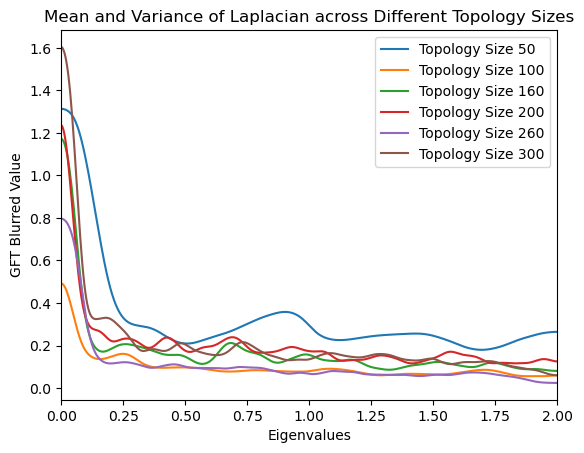

In [15]:
# Replace 'ds_test_50', 'ds_test_100', etc. with your actual dataset variables
datasets = {"50": ds_test_50, "100": ds_test_100, "160": ds_test_160, "200": ds_test_200, "260": ds_test_260, "300": ds_test_300}
all_means = {}
all_vars = {}
all_eigen_values = {}

for ds in datasets.keys():
    eigen_values, mean, var = process_dataset(datasets[ds])
    all_means[ds] = mean
    all_vars[ds] = var
    all_eigen_values[ds] = eigen_values

# Define a common range for eigenvalues
common_eigen_range = np.linspace(0, 2, num=500)  # Adjust the number of points as needed

# Interpolate all datasets to this common range
all_interpolated_means = []
all_interpolated_vars = []

for data_size in datasets.keys():
    # Flatten or average the eigenvalues for each dataset
    # Here we average them
    avg_eigen_values = np.mean(all_eigen_values[data_size], axis=0)

    # Interpolate mean and var for each dataset
    interp_mean = interp1d(avg_eigen_values, all_means[data_size], kind='linear', bounds_error=False, fill_value="extrapolate")
    interpolated_mean = interp_mean(common_eigen_range)

    interp_var = interp1d(avg_eigen_values, all_vars[data_size], kind='linear', bounds_error=False, fill_value="extrapolate")
    interpolated_var = interp_var(common_eigen_range)

    all_interpolated_means.append(interpolated_mean)
    all_interpolated_vars.append(interpolated_var)



for i, (mean, var) in enumerate(zip(all_interpolated_means, all_interpolated_vars)):
    mean = gaussian_filter(np.absolute(mean), sigma=7)
    sns.lineplot(x=common_eigen_range, y=mean, label=f'Topology Size {list(datasets.keys())[i]}')
    plt.fill_between(common_eigen_range, mean - var, mean + var, alpha=0.3)

plt.xlim([0, 2])
plt.xlabel('Eigenvalues')
plt.ylabel('GFT Blurred Value')
plt.title('Mean and Variance of Laplacian across Different Topology Sizes')
plt.legend()
plt.show()